# Loading Modules

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import imageio
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from what_where.main import init, MNIST
from what_where.what import WhatShift, WhatBackground, WhatNet
from stn import STN

# Loading the Data

- Loading the data with the parameters given in the .json file for the What/Where model

In [3]:
args = init(filename='what_where/2020-07-01')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2020-07-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

# Exploring the MNIST with the what noise parameters

- 28x28 pixel with shift and noise

In [46]:
transform=transforms.Compose([
                               WhatShift(args),
                               WhatBackground(contrast = args.contrast,
                                              noise=args.noise, 
                                              sf_0=args.sf_0, 
                                              B_sf=args.B_sf),
                               transforms.ToTensor(),
                               #transforms.Normalize((args.mean,), (args.std,))
                           #transforms.Normalize((0.4914,))
                           ])

dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform,
                        )

train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        )

test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [47]:
def view_dataset(loader: torch.utils.data.DataLoader, n: int=10) -> plt.Figure:
    
    data, label = next(iter(loader))
    fig, axs = plt.subplots(1, n, figsize = (21, 5))
    for i_ax, ax in enumerate(axs):
        ax.imshow(data[i_ax, 0, :, :], cmap=plt.gray())
        ax.set_title("Label = %d"%(label[i_ax].item()))
        ax.set_xticks([])
        ax.set_yticks([])
    return fig

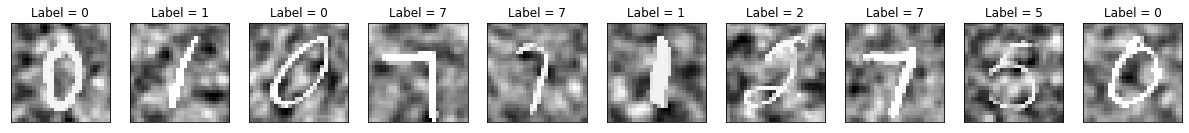

In [48]:
data = view_dataset(train_loader)
#data.savefig('../figures/noisy_no_shift_28x28_data.png')

# Spatial Transformer Network

In [7]:
#model = STN().to(device)
loss_vals=  []
acc_vals = []

In [87]:
def train(epoch, loader):

    epoch_loss= []
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, dtype=torch.float), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        batch_loss = loss.item()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, args.epochs, batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), batch_loss))
        epoch_loss.append(batch_loss)
    #loss_vals.append(sum(epoch_loss)/len(epoch_loss))


def test(loader):

    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in loader:
            data, target = data.to(device,
                                   dtype=torch.float), target.to(device)
            output = model(data)
            test_loss += loss_func(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        
        acc = correct / len(test_loader.dataset)
        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset),
                     100. * acc))
        #acc_vals.append(acc)

In [5]:
for ofst in range(15 + 1):

    args.what_offset_std = ofst
    print("Training on offset_std = %s" % (args.what_offset_std))
    transform = transforms.Compose([
        WhatShift(args),
        WhatBackground(contrast=args.contrast,
                       noise=args.noise,
                       sf_0=args.sf_0,
                       B_sf=args.B_sf),
        transforms.ToTensor(),
        #transforms.Normalize((args.mean,), (args.std,))
    ])

    train_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=True,
        download=True,
        transform=transform,
    ),
                                               batch_size=args.minibatch_size,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=False,
        download=True,
        transform=transform,
    ),
                                              batch_size=args.minibatch_size,
                                              shuffle=True)

    args.epochs = 5
    for epoch in range(1, args.epochs + 1):
        train(epoch, train_loader) 
        test(test_loader)
        stn_grid(epoch)

Training on offset_std = 0
Train Epoch: 1/5 [0/60000 (0%)]	Loss: 2.305109
Train Epoch: 1/5 [10000/60000 (17%)]	Loss: 0.748404
Train Epoch: 1/5 [20000/60000 (33%)]	Loss: 0.221591
Train Epoch: 1/5 [30000/60000 (50%)]	Loss: 0.345198
Train Epoch: 1/5 [40000/60000 (67%)]	Loss: 0.186709
Train Epoch: 1/5 [50000/60000 (83%)]	Loss: 0.173095

Test set: Average loss: 0.0024, Accuracy: 9212/10000 (92%)

Train Epoch: 2/5 [0/60000 (0%)]	Loss: 0.237187
Train Epoch: 2/5 [10000/60000 (17%)]	Loss: 0.182275
Train Epoch: 2/5 [20000/60000 (33%)]	Loss: 0.143588
Train Epoch: 2/5 [30000/60000 (50%)]	Loss: 0.212296
Train Epoch: 2/5 [40000/60000 (67%)]	Loss: 0.153686
Train Epoch: 2/5 [50000/60000 (83%)]	Loss: 0.109039

Test set: Average loss: 0.0017, Accuracy: 9465/10000 (95%)

Train Epoch: 3/5 [0/60000 (0%)]	Loss: 0.137704
Train Epoch: 3/5 [10000/60000 (17%)]	Loss: 0.262396
Train Epoch: 3/5 [20000/60000 (33%)]	Loss: 0.170483
Train Epoch: 3/5 [30000/60000 (50%)]	Loss: 0.103497
Train Epoch: 3/5 [40000/60000 (67%

Train Epoch: 3/5 [10000/60000 (17%)]	Loss: 0.256521
Train Epoch: 3/5 [20000/60000 (33%)]	Loss: 0.315940
Train Epoch: 3/5 [30000/60000 (50%)]	Loss: 0.233822
Train Epoch: 3/5 [40000/60000 (67%)]	Loss: 0.251561
Train Epoch: 3/5 [50000/60000 (83%)]	Loss: 0.181091

Test set: Average loss: 0.0031, Accuracy: 8996/10000 (90%)

Train Epoch: 4/5 [0/60000 (0%)]	Loss: 0.270034
Train Epoch: 4/5 [10000/60000 (17%)]	Loss: 0.198185
Train Epoch: 4/5 [20000/60000 (33%)]	Loss: 0.255903
Train Epoch: 4/5 [30000/60000 (50%)]	Loss: 0.320632
Train Epoch: 4/5 [40000/60000 (67%)]	Loss: 0.179369
Train Epoch: 4/5 [50000/60000 (83%)]	Loss: 0.289109

Test set: Average loss: 0.0033, Accuracy: 8948/10000 (89%)

Train Epoch: 5/5 [0/60000 (0%)]	Loss: 0.233097
Train Epoch: 5/5 [10000/60000 (17%)]	Loss: 0.253872
Train Epoch: 5/5 [20000/60000 (33%)]	Loss: 0.203767
Train Epoch: 5/5 [30000/60000 (50%)]	Loss: 0.295917
Train Epoch: 5/5 [40000/60000 (67%)]	Loss: 0.306228
Train Epoch: 5/5 [50000/60000 (83%)]	Loss: 0.312181

Tes

Train Epoch: 5/5 [10000/60000 (17%)]	Loss: 0.689225
Train Epoch: 5/5 [20000/60000 (33%)]	Loss: 0.778427
Train Epoch: 5/5 [30000/60000 (50%)]	Loss: 0.916448
Train Epoch: 5/5 [40000/60000 (67%)]	Loss: 1.011980
Train Epoch: 5/5 [50000/60000 (83%)]	Loss: 0.580581

Test set: Average loss: 0.0076, Accuracy: 7418/10000 (74%)

Training on offset_std = 9
Train Epoch: 1/5 [0/60000 (0%)]	Loss: 0.886990
Train Epoch: 1/5 [10000/60000 (17%)]	Loss: 0.943980
Train Epoch: 1/5 [20000/60000 (33%)]	Loss: 0.976475
Train Epoch: 1/5 [30000/60000 (50%)]	Loss: 0.974596
Train Epoch: 1/5 [40000/60000 (67%)]	Loss: 0.981652
Train Epoch: 1/5 [50000/60000 (83%)]	Loss: 0.797158

Test set: Average loss: 0.0087, Accuracy: 6946/10000 (69%)

Train Epoch: 2/5 [0/60000 (0%)]	Loss: 0.837512
Train Epoch: 2/5 [10000/60000 (17%)]	Loss: 0.869571
Train Epoch: 2/5 [20000/60000 (33%)]	Loss: 0.688806
Train Epoch: 2/5 [30000/60000 (50%)]	Loss: 1.112775
Train Epoch: 2/5 [40000/60000 (67%)]	Loss: 0.848797
Train Epoch: 2/5 [50000/60000

Train Epoch: 2/5 [10000/60000 (17%)]	Loss: 1.413358
Train Epoch: 2/5 [20000/60000 (33%)]	Loss: 1.457345
Train Epoch: 2/5 [30000/60000 (50%)]	Loss: 1.222553
Train Epoch: 2/5 [40000/60000 (67%)]	Loss: 1.418793
Train Epoch: 2/5 [50000/60000 (83%)]	Loss: 1.280933

Test set: Average loss: 0.0133, Accuracy: 5147/10000 (51%)

Train Epoch: 3/5 [0/60000 (0%)]	Loss: 1.508637
Train Epoch: 3/5 [10000/60000 (17%)]	Loss: 1.275140
Train Epoch: 3/5 [20000/60000 (33%)]	Loss: 1.218848
Train Epoch: 3/5 [30000/60000 (50%)]	Loss: 1.150504
Train Epoch: 3/5 [40000/60000 (67%)]	Loss: 1.395778
Train Epoch: 3/5 [50000/60000 (83%)]	Loss: 1.325454

Test set: Average loss: 0.0132, Accuracy: 5146/10000 (51%)

Train Epoch: 4/5 [0/60000 (0%)]	Loss: 1.347433
Train Epoch: 4/5 [10000/60000 (17%)]	Loss: 1.241416
Train Epoch: 4/5 [20000/60000 (33%)]	Loss: 1.058323
Train Epoch: 4/5 [30000/60000 (50%)]	Loss: 1.467258
Train Epoch: 4/5 [40000/60000 (67%)]	Loss: 1.291741
Train Epoch: 4/5 [50000/60000 (83%)]	Loss: 1.134848

Tes

# Saving the model

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = "../models/stn_28x28_shift_dependant.pt"
#torch.save(model, PATH)

# General accuracy

In [18]:
model = torch.load(PATH).to(device)
optimizer = optim.Adam(model.parameters(), lr=args.lr)
loss_func = nn.CrossEntropyLoss()

In [19]:
args.what_offset_std

15

In [20]:
test(test_loader)


Test set: Average loss: 0.0150, Accuracy: 4474/10000 (45%)



# Central accuracy

In [21]:
args.what_offset_std = 0
test_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)

In [22]:
test(test_loader)


Test set: Average loss: 0.0026, Accuracy: 9258/10000 (93%)



# Loss and accuracy over epochs

In [2]:
acc_vals = [
    0.9212, 0.9465, 0.9346, 0.9454, 0.9597, 0.9519, 0.948, 0.9519, 0.9443,
    0.965, 0.9357, 0.9371, 0.9465, 0.948, 0.9414, 0.9105, 0.9178, 0.918,
    0.9123, 0.9241, 0.8989, 0.8924, 0.8996, 0.8948, 0.8964, 0.8583, 0.8642,
    0.8674, 0.8648, 0.8603, 0.816, 0.8251, 0.8319, 0.833, 0.8315, 0.7851,
    0.7809, 0.7908, 0.7721, 0.7894, 0.7412, 0.7383, 0.7321, 0.732, 0.7418,
    0.6946, 0.6888, 0.68, 0.6791, 0.6981, 0.632, 0.6409, 0.6459, 0.6359,
    0.6482, 0.6047, 0.603, 0.6063, 0.5933, 0.6101, 0.5535, 0.5584, 0.5616,
    0.5647, 0.5695, 0.5225, 0.5147, 0.5146, 0.5212, 0.5209, 0.4905, 0.4848,
    0.4826, 0.4765, 0.4859, 0.4591, 0.4355, 0.447, 0.4519, 0.4474
]

loss_vals = [
    0.5363115456948677, 0.21481517302493255, 0.17712997642035286,
    0.15243715243414044, 0.1424578868690878, 0.20101315242238343,
    0.15388391388580203, 0.14071135501687726, 0.12534158758974323,
    0.11300092256627976, 0.26995844694475335, 0.20451272916980087,
    0.18131722542146841, 0.16338372446596622, 0.1611711127993961,
    0.34000613282124204, 0.27114262585838633, 0.24132816986491282,
    0.2267733787683149, 0.21164495915795367, 0.39375388987362386,
    0.34500322548051676, 0.3156716384490331, 0.3114680112153292,
    0.28847724581758183, 0.4666968093564113, 0.4250456781188647,
    0.40703780986368654, 0.3866389628499746, 0.3756144955009222,
    0.5638208948572476, 0.5153775257368882, 0.4990404806534449,
    0.48409683528045816, 0.4804590239127477, 0.6560966618855795,
    0.6357123577594757, 0.6224498630066713, 0.6038525615135829,
    0.5922633693615595, 0.777882082760334, 0.7632829301555951,
    0.731719941397508, 0.720598082691431, 0.7241339672605197,
    0.8925080551703771, 0.8657866797844569, 0.8606228210528691,
    0.8415170080463091, 0.8407456308603287, 1.0074945114056268,
    0.9878585279981296, 0.9793049477537473, 0.9691978773474693,
    0.9604261054595311, 1.1164324897527695, 1.098145569662253,
    1.0919223367174467, 1.08174374828736, 1.074712206820647, 1.223612820804119,
    1.2062699973583222, 1.2012111162145933, 1.1977179376284282,
    1.1901200460394223, 1.3202106285095214, 1.3138329301277796,
    1.300054999490579, 1.2949701497952144, 1.298184091746807,
    1.4157388349374136, 1.4046614128351211, 1.4025987563530604,
    1.3999317047993343, 1.3861088727911313, 1.4906338012218476,
    1.4860538440942763, 1.4900581993659336, 1.4732174746195474,
    1.4640471905469894
]

Text(0.5, 0.98, 'STN - Training \n Shift $\\sigma \\in [0,15]$, every 5 epochs')

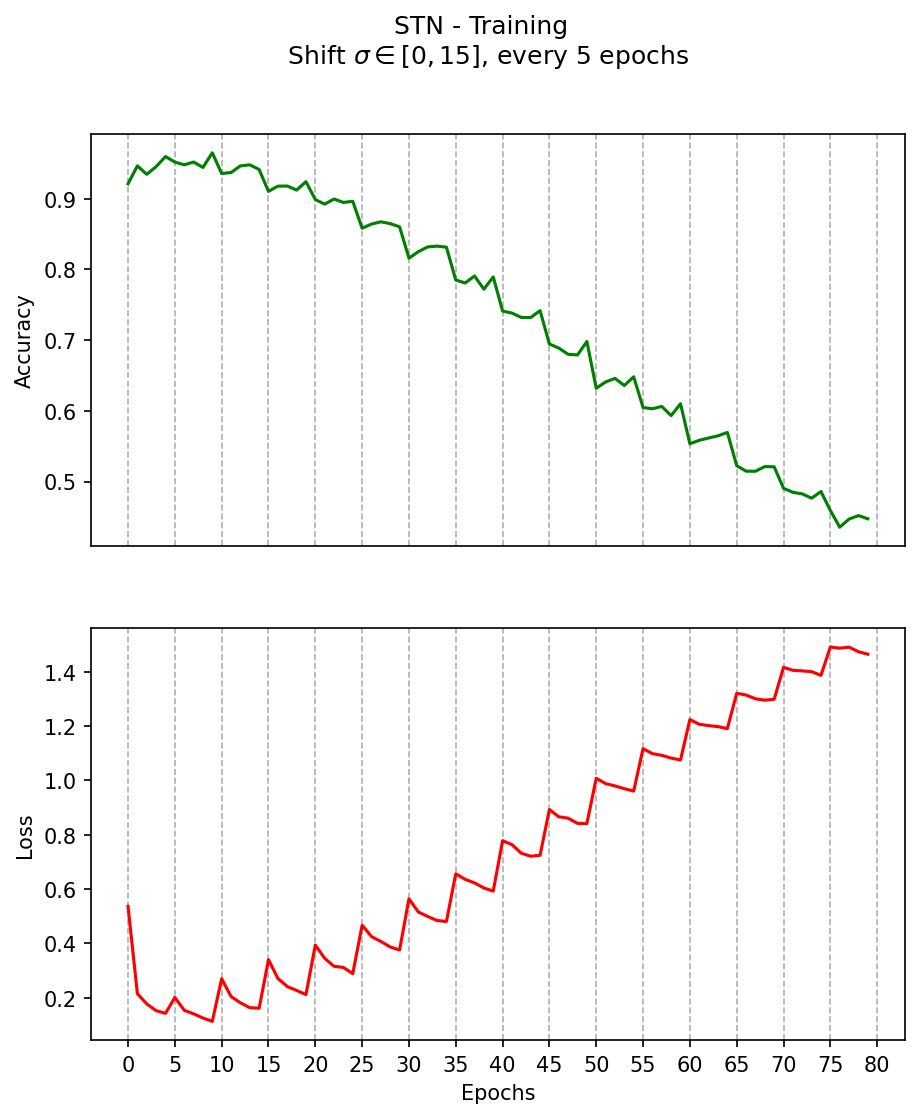

In [13]:
fig, ax = plt.subplots(2, 1, dpi=150, figsize=(7, 8))
ax[0].plot(acc_vals, 'g')
ax[1].plot(loss_vals, 'r')

for i in range(2):
    ax[i].set_xticks([e for e in range(0, 85, 5)])

ax[0].tick_params(axis='x',  which='both',  bottom=False,
                  top=False, labelbottom=False)
    
ax[0].set_ylabel("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")


for i in range(2):
    ax[i].grid(axis='x', linestyle='--')
fig.suptitle("STN - Training \n Shift $\sigma \in [0,15]$, every 5 epochs")
#fig.savefig('../figures/loss_acc_training_stn_28x28.png')

# Accuracy map

## Generating and saving the accuracy map

In [32]:
accuracy_map = np.zeros((55, 55))
for i in range(-27,28):
    for j in range(-27,28):
        transform=transforms.Compose([
                               WhatShift(args, i_offset=i, j_offset=j),
                               WhatBackground(contrast = args.contrast,
                                              noise=args.noise, 
                                              sf_0=args.sf_0, 
                                              B_sf=args.B_sf),
                               transforms.ToTensor(),
                               #transforms.Normalize((args.mean,), (args.std,))
                           ])
        test_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)
        accuracy = test(test_loader)
        accuracy_map[i + 27, j + 27] = accuracy 
        print(i, j, accuracy)


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -26 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -25 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -24 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -23 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -22 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -21 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -20 0.1135

Test set: Average loss: 0.0230, Accuracy: 1138/10000 (11%)

-27 -19 0.1138

Test set: Average loss: 0.0230, Accuracy: 1138/10000 (11%)

-27 -18 0.1138

Test set: Average loss: 0.0230, Accuracy: 1145/10000 (11%)

-27 -17 0.1145

Test set: Average loss: 0.0230, Accuracy: 1144/10000 (11%)

-27 -16 0.1144

Test set: Average loss: 0.0230, Accuracy: 1153/10000 (12%)

-27 -15 0.1153

Test set: A


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-25 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-25 -26 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-25 -25 0.1135

Test set: Average loss: 0.0230, Accuracy: 1136/10000 (11%)

-25 -24 0.1136

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-25 -23 0.1135

Test set: Average loss: 0.0230, Accuracy: 1137/10000 (11%)

-25 -22 0.1137

Test set: Average loss: 0.0230, Accuracy: 1140/10000 (11%)

-25 -21 0.114

Test set: Average loss: 0.0230, Accuracy: 1154/10000 (12%)

-25 -20 0.1154

Test set: Average loss: 0.0230, Accuracy: 1161/10000 (12%)

-25 -19 0.1161

Test set: Average loss: 0.0230, Accuracy: 1186/10000 (12%)

-25 -18 0.1186

Test set: Average loss: 0.0230, Accuracy: 1238/10000 (12%)

-25 -17 0.1238

Test set: Average loss: 0.0230, Accuracy: 1275/10000 (13%)

-25 -16 0.1275

Test set: Average loss: 0.0229, Accuracy: 1314/10000 (13%)

-25 -15 0.1314

Test set: Av


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-23 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-23 -26 0.1135

Test set: Average loss: 0.0230, Accuracy: 1138/10000 (11%)

-23 -25 0.1138

Test set: Average loss: 0.0230, Accuracy: 1136/10000 (11%)

-23 -24 0.1136

Test set: Average loss: 0.0230, Accuracy: 1139/10000 (11%)

-23 -23 0.1139

Test set: Average loss: 0.0230, Accuracy: 1145/10000 (11%)

-23 -22 0.1145

Test set: Average loss: 0.0230, Accuracy: 1154/10000 (12%)

-23 -21 0.1154

Test set: Average loss: 0.0231, Accuracy: 1176/10000 (12%)

-23 -20 0.1176

Test set: Average loss: 0.0231, Accuracy: 1206/10000 (12%)

-23 -19 0.1206

Test set: Average loss: 0.0231, Accuracy: 1204/10000 (12%)

-23 -18 0.1204

Test set: Average loss: 0.0231, Accuracy: 1262/10000 (13%)

-23 -17 0.1262

Test set: Average loss: 0.0232, Accuracy: 1215/10000 (12%)

-23 -16 0.1215

Test set: Average loss: 0.0232, Accuracy: 1169/10000 (12%)

-23 -15 0.1169

Test set: A


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-21 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-21 -26 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-21 -25 0.1135

Test set: Average loss: 0.0231, Accuracy: 1137/10000 (11%)

-21 -24 0.1137

Test set: Average loss: 0.0231, Accuracy: 1136/10000 (11%)

-21 -23 0.1136

Test set: Average loss: 0.0231, Accuracy: 1148/10000 (11%)

-21 -22 0.1148

Test set: Average loss: 0.0232, Accuracy: 1164/10000 (12%)

-21 -21 0.1164

Test set: Average loss: 0.0232, Accuracy: 1194/10000 (12%)

-21 -20 0.1194

Test set: Average loss: 0.0234, Accuracy: 1223/10000 (12%)

-21 -19 0.1223

Test set: Average loss: 0.0235, Accuracy: 1315/10000 (13%)

-21 -18 0.1315

Test set: Average loss: 0.0235, Accuracy: 1370/10000 (14%)

-21 -17 0.137

Test set: Average loss: 0.0235, Accuracy: 1337/10000 (13%)

-21 -16 0.1337

Test set: Average loss: 0.0234, Accuracy: 1337/10000 (13%)

-21 -15 0.1337

Test set: Av


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-19 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1134/10000 (11%)

-19 -26 0.1134

Test set: Average loss: 0.0231, Accuracy: 1137/10000 (11%)

-19 -25 0.1137

Test set: Average loss: 0.0231, Accuracy: 1138/10000 (11%)

-19 -24 0.1138

Test set: Average loss: 0.0231, Accuracy: 1143/10000 (11%)

-19 -23 0.1143

Test set: Average loss: 0.0232, Accuracy: 1182/10000 (12%)

-19 -22 0.1182

Test set: Average loss: 0.0234, Accuracy: 1197/10000 (12%)

-19 -21 0.1197

Test set: Average loss: 0.0235, Accuracy: 1276/10000 (13%)

-19 -20 0.1276

Test set: Average loss: 0.0236, Accuracy: 1300/10000 (13%)

-19 -19 0.13

Test set: Average loss: 0.0236, Accuracy: 1471/10000 (15%)

-19 -18 0.1471

Test set: Average loss: 0.0236, Accuracy: 1539/10000 (15%)

-19 -17 0.1539

Test set: Average loss: 0.0234, Accuracy: 1589/10000 (16%)

-19 -16 0.1589

Test set: Average loss: 0.0232, Accuracy: 1631/10000 (16%)

-19 -15 0.1631

Test set: Ave


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-17 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1136/10000 (11%)

-17 -26 0.1136

Test set: Average loss: 0.0231, Accuracy: 1138/10000 (11%)

-17 -25 0.1138

Test set: Average loss: 0.0231, Accuracy: 1144/10000 (11%)

-17 -24 0.1144

Test set: Average loss: 0.0233, Accuracy: 1177/10000 (12%)

-17 -23 0.1177

Test set: Average loss: 0.0234, Accuracy: 1196/10000 (12%)

-17 -22 0.1196

Test set: Average loss: 0.0235, Accuracy: 1292/10000 (13%)

-17 -21 0.1292

Test set: Average loss: 0.0236, Accuracy: 1370/10000 (14%)

-17 -20 0.137

Test set: Average loss: 0.0236, Accuracy: 1499/10000 (15%)

-17 -19 0.1499

Test set: Average loss: 0.0236, Accuracy: 1685/10000 (17%)

-17 -18 0.1685

Test set: Average loss: 0.0236, Accuracy: 1867/10000 (19%)

-17 -17 0.1867

Test set: Average loss: 0.0235, Accuracy: 1817/10000 (18%)

-17 -16 0.1817

Test set: Average loss: 0.0231, Accuracy: 1649/10000 (16%)

-17 -15 0.1649

Test set: Av


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-15 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-15 -26 0.1135

Test set: Average loss: 0.0231, Accuracy: 1143/10000 (11%)

-15 -25 0.1143

Test set: Average loss: 0.0232, Accuracy: 1170/10000 (12%)

-15 -24 0.117

Test set: Average loss: 0.0233, Accuracy: 1185/10000 (12%)

-15 -23 0.1185

Test set: Average loss: 0.0234, Accuracy: 1246/10000 (12%)

-15 -22 0.1246

Test set: Average loss: 0.0235, Accuracy: 1354/10000 (14%)

-15 -21 0.1354

Test set: Average loss: 0.0235, Accuracy: 1481/10000 (15%)

-15 -20 0.1481

Test set: Average loss: 0.0235, Accuracy: 1700/10000 (17%)

-15 -19 0.17

Test set: Average loss: 0.0236, Accuracy: 1884/10000 (19%)

-15 -18 0.1884

Test set: Average loss: 0.0236, Accuracy: 1956/10000 (20%)

-15 -17 0.1956

Test set: Average loss: 0.0231, Accuracy: 1833/10000 (18%)

-15 -16 0.1833

Test set: Average loss: 0.0222, Accuracy: 1827/10000 (18%)

-15 -15 0.1827

Test set: Aver


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-13 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1136/10000 (11%)

-13 -26 0.1136

Test set: Average loss: 0.0231, Accuracy: 1140/10000 (11%)

-13 -25 0.114

Test set: Average loss: 0.0232, Accuracy: 1159/10000 (12%)

-13 -24 0.1159

Test set: Average loss: 0.0233, Accuracy: 1188/10000 (12%)

-13 -23 0.1188

Test set: Average loss: 0.0234, Accuracy: 1266/10000 (13%)

-13 -22 0.1266

Test set: Average loss: 0.0234, Accuracy: 1415/10000 (14%)

-13 -21 0.1415

Test set: Average loss: 0.0234, Accuracy: 1617/10000 (16%)

-13 -20 0.1617

Test set: Average loss: 0.0233, Accuracy: 1851/10000 (19%)

-13 -19 0.1851

Test set: Average loss: 0.0231, Accuracy: 2033/10000 (20%)

-13 -18 0.2033

Test set: Average loss: 0.0227, Accuracy: 2002/10000 (20%)

-13 -17 0.2002

Test set: Average loss: 0.0216, Accuracy: 1962/10000 (20%)

-13 -16 0.1962

Test set: Average loss: 0.0205, Accuracy: 2321/10000 (23%)

-13 -15 0.2321

Test set: Av


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-11 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1134/10000 (11%)

-11 -26 0.1134

Test set: Average loss: 0.0231, Accuracy: 1148/10000 (11%)

-11 -25 0.1148

Test set: Average loss: 0.0232, Accuracy: 1159/10000 (12%)

-11 -24 0.1159

Test set: Average loss: 0.0233, Accuracy: 1223/10000 (12%)

-11 -23 0.1223

Test set: Average loss: 0.0233, Accuracy: 1345/10000 (13%)

-11 -22 0.1345

Test set: Average loss: 0.0233, Accuracy: 1481/10000 (15%)

-11 -21 0.1481

Test set: Average loss: 0.0232, Accuracy: 1719/10000 (17%)

-11 -20 0.1719

Test set: Average loss: 0.0231, Accuracy: 1925/10000 (19%)

-11 -19 0.1925

Test set: Average loss: 0.0226, Accuracy: 1992/10000 (20%)

-11 -18 0.1992

Test set: Average loss: 0.0218, Accuracy: 2031/10000 (20%)

-11 -17 0.2031

Test set: Average loss: 0.0206, Accuracy: 2181/10000 (22%)

-11 -16 0.2181

Test set: Average loss: 0.0191, Accuracy: 2950/10000 (30%)

-11 -15 0.295

Test set: Av


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-9 -27 0.1135

Test set: Average loss: 0.0231, Accuracy: 1137/10000 (11%)

-9 -26 0.1137

Test set: Average loss: 0.0231, Accuracy: 1143/10000 (11%)

-9 -25 0.1143

Test set: Average loss: 0.0232, Accuracy: 1188/10000 (12%)

-9 -24 0.1188

Test set: Average loss: 0.0233, Accuracy: 1269/10000 (13%)

-9 -23 0.1269

Test set: Average loss: 0.0233, Accuracy: 1383/10000 (14%)

-9 -22 0.1383

Test set: Average loss: 0.0233, Accuracy: 1623/10000 (16%)

-9 -21 0.1623

Test set: Average loss: 0.0231, Accuracy: 1739/10000 (17%)

-9 -20 0.1739

Test set: Average loss: 0.0229, Accuracy: 1898/10000 (19%)

-9 -19 0.1898

Test set: Average loss: 0.0223, Accuracy: 1951/10000 (20%)

-9 -18 0.1951

Test set: Average loss: 0.0214, Accuracy: 2241/10000 (22%)

-9 -17 0.2241

Test set: Average loss: 0.0197, Accuracy: 2789/10000 (28%)

-9 -16 0.2789

Test set: Average loss: 0.0176, Accuracy: 3792/10000 (38%)

-9 -15 0.3792

Test set: Average loss: 


Test set: Average loss: 0.0231, Accuracy: 1136/10000 (11%)

-7 -26 0.1136

Test set: Average loss: 0.0231, Accuracy: 1154/10000 (12%)

-7 -25 0.1154

Test set: Average loss: 0.0232, Accuracy: 1204/10000 (12%)

-7 -24 0.1204

Test set: Average loss: 0.0233, Accuracy: 1268/10000 (13%)

-7 -23 0.1268

Test set: Average loss: 0.0233, Accuracy: 1420/10000 (14%)

-7 -22 0.142

Test set: Average loss: 0.0233, Accuracy: 1581/10000 (16%)

-7 -21 0.1581

Test set: Average loss: 0.0231, Accuracy: 1674/10000 (17%)

-7 -20 0.1674

Test set: Average loss: 0.0229, Accuracy: 1918/10000 (19%)

-7 -19 0.1918

Test set: Average loss: 0.0224, Accuracy: 2088/10000 (21%)

-7 -18 0.2088

Test set: Average loss: 0.0208, Accuracy: 2629/10000 (26%)

-7 -17 0.2629

Test set: Average loss: 0.0191, Accuracy: 3331/10000 (33%)

-7 -16 0.3331

Test set: Average loss: 0.0166, Accuracy: 4324/10000 (43%)

-7 -15 0.4324

Test set: Average loss: 0.0144, Accuracy: 5102/10000 (51%)

-7 -14 0.5102

Test set: Average loss: 0


Test set: Average loss: 0.0231, Accuracy: 1152/10000 (12%)

-5 -25 0.1152

Test set: Average loss: 0.0232, Accuracy: 1204/10000 (12%)

-5 -24 0.1204

Test set: Average loss: 0.0233, Accuracy: 1281/10000 (13%)

-5 -23 0.1281

Test set: Average loss: 0.0232, Accuracy: 1426/10000 (14%)

-5 -22 0.1426

Test set: Average loss: 0.0232, Accuracy: 1581/10000 (16%)

-5 -21 0.1581

Test set: Average loss: 0.0230, Accuracy: 1862/10000 (19%)

-5 -20 0.1862

Test set: Average loss: 0.0227, Accuracy: 2068/10000 (21%)

-5 -19 0.2068

Test set: Average loss: 0.0220, Accuracy: 2367/10000 (24%)

-5 -18 0.2367

Test set: Average loss: 0.0206, Accuracy: 2918/10000 (29%)

-5 -17 0.2918

Test set: Average loss: 0.0185, Accuracy: 3585/10000 (36%)

-5 -16 0.3585

Test set: Average loss: 0.0158, Accuracy: 4595/10000 (46%)

-5 -15 0.4595

Test set: Average loss: 0.0131, Accuracy: 5436/10000 (54%)

-5 -14 0.5436

Test set: Average loss: 0.0113, Accuracy: 6093/10000 (61%)

-5 -13 0.6093

Test set: Average loss: 


Test set: Average loss: 0.0232, Accuracy: 1206/10000 (12%)

-3 -24 0.1206

Test set: Average loss: 0.0233, Accuracy: 1277/10000 (13%)

-3 -23 0.1277

Test set: Average loss: 0.0232, Accuracy: 1470/10000 (15%)

-3 -22 0.147

Test set: Average loss: 0.0230, Accuracy: 1766/10000 (18%)

-3 -21 0.1766

Test set: Average loss: 0.0227, Accuracy: 1985/10000 (20%)

-3 -20 0.1985

Test set: Average loss: 0.0222, Accuracy: 2368/10000 (24%)

-3 -19 0.2368

Test set: Average loss: 0.0213, Accuracy: 2700/10000 (27%)

-3 -18 0.27

Test set: Average loss: 0.0198, Accuracy: 3154/10000 (32%)

-3 -17 0.3154

Test set: Average loss: 0.0177, Accuracy: 3849/10000 (38%)

-3 -16 0.3849

Test set: Average loss: 0.0150, Accuracy: 4768/10000 (48%)

-3 -15 0.4768

Test set: Average loss: 0.0126, Accuracy: 5580/10000 (56%)

-3 -14 0.558

Test set: Average loss: 0.0103, Accuracy: 6470/10000 (65%)

-3 -13 0.647

Test set: Average loss: 0.0086, Accuracy: 7144/10000 (71%)

-3 -12 0.7144

Test set: Average loss: 0.007


Test set: Average loss: 0.0233, Accuracy: 1318/10000 (13%)

-1 -23 0.1318

Test set: Average loss: 0.0232, Accuracy: 1496/10000 (15%)

-1 -22 0.1496

Test set: Average loss: 0.0229, Accuracy: 1835/10000 (18%)

-1 -21 0.1835

Test set: Average loss: 0.0226, Accuracy: 2113/10000 (21%)

-1 -20 0.2113

Test set: Average loss: 0.0219, Accuracy: 2393/10000 (24%)

-1 -19 0.2393

Test set: Average loss: 0.0209, Accuracy: 2902/10000 (29%)

-1 -18 0.2902

Test set: Average loss: 0.0191, Accuracy: 3479/10000 (35%)

-1 -17 0.3479

Test set: Average loss: 0.0168, Accuracy: 4189/10000 (42%)

-1 -16 0.4189

Test set: Average loss: 0.0140, Accuracy: 5269/10000 (53%)

-1 -15 0.5269

Test set: Average loss: 0.0117, Accuracy: 6074/10000 (61%)

-1 -14 0.6074

Test set: Average loss: 0.0095, Accuracy: 6766/10000 (68%)

-1 -13 0.6766

Test set: Average loss: 0.0078, Accuracy: 7466/10000 (75%)

-1 -12 0.7466

Test set: Average loss: 0.0064, Accuracy: 7992/10000 (80%)

-1 -11 0.7992

Test set: Average loss: 


Test set: Average loss: 0.0230, Accuracy: 1729/10000 (17%)

1 -21 0.1729

Test set: Average loss: 0.0227, Accuracy: 1983/10000 (20%)

1 -20 0.1983

Test set: Average loss: 0.0222, Accuracy: 2278/10000 (23%)

1 -19 0.2278

Test set: Average loss: 0.0211, Accuracy: 2693/10000 (27%)

1 -18 0.2693

Test set: Average loss: 0.0192, Accuracy: 3356/10000 (34%)

1 -17 0.3356

Test set: Average loss: 0.0167, Accuracy: 4216/10000 (42%)

1 -16 0.4216

Test set: Average loss: 0.0140, Accuracy: 5253/10000 (53%)

1 -15 0.5253

Test set: Average loss: 0.0118, Accuracy: 5942/10000 (59%)

1 -14 0.5942

Test set: Average loss: 0.0099, Accuracy: 6606/10000 (66%)

1 -13 0.6606

Test set: Average loss: 0.0082, Accuracy: 7315/10000 (73%)

1 -12 0.7315

Test set: Average loss: 0.0069, Accuracy: 7785/10000 (78%)

1 -11 0.7785

Test set: Average loss: 0.0054, Accuracy: 8290/10000 (83%)

1 -10 0.829

Test set: Average loss: 0.0045, Accuracy: 8601/10000 (86%)

1 -9 0.8601

Test set: Average loss: 0.0040, Accurac


Test set: Average loss: 0.0217, Accuracy: 2416/10000 (24%)

3 -18 0.2416

Test set: Average loss: 0.0201, Accuracy: 3014/10000 (30%)

3 -17 0.3014

Test set: Average loss: 0.0178, Accuracy: 3761/10000 (38%)

3 -16 0.3761

Test set: Average loss: 0.0153, Accuracy: 4570/10000 (46%)

3 -15 0.457

Test set: Average loss: 0.0130, Accuracy: 5496/10000 (55%)

3 -14 0.5496

Test set: Average loss: 0.0112, Accuracy: 6152/10000 (62%)

3 -13 0.6152

Test set: Average loss: 0.0092, Accuracy: 6945/10000 (69%)

3 -12 0.6945

Test set: Average loss: 0.0076, Accuracy: 7546/10000 (75%)

3 -11 0.7546

Test set: Average loss: 0.0062, Accuracy: 8024/10000 (80%)

3 -10 0.8024

Test set: Average loss: 0.0055, Accuracy: 8337/10000 (83%)

3 -9 0.8337

Test set: Average loss: 0.0047, Accuracy: 8525/10000 (85%)

3 -8 0.8525

Test set: Average loss: 0.0042, Accuracy: 8693/10000 (87%)

3 -7 0.8693

Test set: Average loss: 0.0037, Accuracy: 8876/10000 (89%)

3 -6 0.8876

Test set: Average loss: 0.0038, Accuracy: 


Test set: Average loss: 0.0167, Accuracy: 4245/10000 (42%)

5 -15 0.4245

Test set: Average loss: 0.0141, Accuracy: 5244/10000 (52%)

5 -14 0.5244

Test set: Average loss: 0.0119, Accuracy: 5999/10000 (60%)

5 -13 0.5999

Test set: Average loss: 0.0100, Accuracy: 6737/10000 (67%)

5 -12 0.6737

Test set: Average loss: 0.0084, Accuracy: 7283/10000 (73%)

5 -11 0.7283

Test set: Average loss: 0.0075, Accuracy: 7632/10000 (76%)

5 -10 0.7632

Test set: Average loss: 0.0066, Accuracy: 7934/10000 (79%)

5 -9 0.7934

Test set: Average loss: 0.0058, Accuracy: 8227/10000 (82%)

5 -8 0.8227

Test set: Average loss: 0.0052, Accuracy: 8461/10000 (85%)

5 -7 0.8461

Test set: Average loss: 0.0049, Accuracy: 8519/10000 (85%)

5 -6 0.8519

Test set: Average loss: 0.0047, Accuracy: 8608/10000 (86%)

5 -5 0.8608

Test set: Average loss: 0.0044, Accuracy: 8678/10000 (87%)

5 -4 0.8678

Test set: Average loss: 0.0040, Accuracy: 8821/10000 (88%)

5 -3 0.8821

Test set: Average loss: 0.0036, Accuracy: 89


Test set: Average loss: 0.0113, Accuracy: 6270/10000 (63%)

7 -12 0.627

Test set: Average loss: 0.0101, Accuracy: 6703/10000 (67%)

7 -11 0.6703

Test set: Average loss: 0.0091, Accuracy: 7097/10000 (71%)

7 -10 0.7097

Test set: Average loss: 0.0085, Accuracy: 7330/10000 (73%)

7 -9 0.733

Test set: Average loss: 0.0075, Accuracy: 7666/10000 (77%)

7 -8 0.7666

Test set: Average loss: 0.0069, Accuracy: 7876/10000 (79%)

7 -7 0.7876

Test set: Average loss: 0.0064, Accuracy: 8060/10000 (81%)

7 -6 0.806

Test set: Average loss: 0.0060, Accuracy: 8154/10000 (82%)

7 -5 0.8154

Test set: Average loss: 0.0055, Accuracy: 8304/10000 (83%)

7 -4 0.8304

Test set: Average loss: 0.0051, Accuracy: 8479/10000 (85%)

7 -3 0.8479

Test set: Average loss: 0.0046, Accuracy: 8621/10000 (86%)

7 -2 0.8621

Test set: Average loss: 0.0044, Accuracy: 8659/10000 (87%)

7 -1 0.8659

Test set: Average loss: 0.0042, Accuracy: 8766/10000 (88%)

7 0 0.8766

Test set: Average loss: 0.0046, Accuracy: 8659/1000


Test set: Average loss: 0.0099, Accuracy: 6719/10000 (67%)

9 -9 0.6719

Test set: Average loss: 0.0089, Accuracy: 7052/10000 (71%)

9 -8 0.7052

Test set: Average loss: 0.0081, Accuracy: 7392/10000 (74%)

9 -7 0.7392

Test set: Average loss: 0.0076, Accuracy: 7559/10000 (76%)

9 -6 0.7559

Test set: Average loss: 0.0069, Accuracy: 7857/10000 (79%)

9 -5 0.7857

Test set: Average loss: 0.0065, Accuracy: 7910/10000 (79%)

9 -4 0.791

Test set: Average loss: 0.0061, Accuracy: 8035/10000 (80%)

9 -3 0.8035

Test set: Average loss: 0.0055, Accuracy: 8263/10000 (83%)

9 -2 0.8263

Test set: Average loss: 0.0053, Accuracy: 8337/10000 (83%)

9 -1 0.8337

Test set: Average loss: 0.0055, Accuracy: 8355/10000 (84%)

9 0 0.8355

Test set: Average loss: 0.0055, Accuracy: 8334/10000 (83%)

9 1 0.8334

Test set: Average loss: 0.0054, Accuracy: 8377/10000 (84%)

9 2 0.8377

Test set: Average loss: 0.0053, Accuracy: 8322/10000 (83%)

9 3 0.8322

Test set: Average loss: 0.0057, Accuracy: 8169/10000 (8


Test set: Average loss: 0.0092, Accuracy: 6893/10000 (69%)

11 -7 0.6893

Test set: Average loss: 0.0087, Accuracy: 7085/10000 (71%)

11 -6 0.7085

Test set: Average loss: 0.0080, Accuracy: 7297/10000 (73%)

11 -5 0.7297

Test set: Average loss: 0.0078, Accuracy: 7451/10000 (75%)

11 -4 0.7451

Test set: Average loss: 0.0073, Accuracy: 7559/10000 (76%)

11 -3 0.7559

Test set: Average loss: 0.0073, Accuracy: 7592/10000 (76%)

11 -2 0.7592

Test set: Average loss: 0.0073, Accuracy: 7586/10000 (76%)

11 -1 0.7586

Test set: Average loss: 0.0069, Accuracy: 7759/10000 (78%)

11 0 0.7759

Test set: Average loss: 0.0067, Accuracy: 7784/10000 (78%)

11 1 0.7784

Test set: Average loss: 0.0070, Accuracy: 7726/10000 (77%)

11 2 0.7726

Test set: Average loss: 0.0073, Accuracy: 7556/10000 (76%)

11 3 0.7556

Test set: Average loss: 0.0078, Accuracy: 7325/10000 (73%)

11 4 0.7325

Test set: Average loss: 0.0085, Accuracy: 7096/10000 (71%)

11 5 0.7096

Test set: Average loss: 0.0093, Accuracy: 6


Test set: Average loss: 0.0109, Accuracy: 6259/10000 (63%)

13 -6 0.6259

Test set: Average loss: 0.0105, Accuracy: 6373/10000 (64%)

13 -5 0.6373

Test set: Average loss: 0.0102, Accuracy: 6519/10000 (65%)

13 -4 0.6519

Test set: Average loss: 0.0099, Accuracy: 6608/10000 (66%)

13 -3 0.6608

Test set: Average loss: 0.0099, Accuracy: 6583/10000 (66%)

13 -2 0.6583

Test set: Average loss: 0.0097, Accuracy: 6640/10000 (66%)

13 -1 0.664

Test set: Average loss: 0.0096, Accuracy: 6634/10000 (66%)

13 0 0.6634

Test set: Average loss: 0.0096, Accuracy: 6597/10000 (66%)

13 1 0.6597

Test set: Average loss: 0.0100, Accuracy: 6518/10000 (65%)

13 2 0.6518

Test set: Average loss: 0.0105, Accuracy: 6362/10000 (64%)

13 3 0.6362

Test set: Average loss: 0.0110, Accuracy: 6155/10000 (62%)

13 4 0.6155

Test set: Average loss: 0.0117, Accuracy: 5912/10000 (59%)

13 5 0.5912

Test set: Average loss: 0.0122, Accuracy: 5699/10000 (57%)

13 6 0.5699

Test set: Average loss: 0.0130, Accuracy: 523


Test set: Average loss: 0.0141, Accuracy: 4854/10000 (49%)

15 -5 0.4854

Test set: Average loss: 0.0139, Accuracy: 4941/10000 (49%)

15 -4 0.4941

Test set: Average loss: 0.0140, Accuracy: 4945/10000 (49%)

15 -3 0.4945

Test set: Average loss: 0.0136, Accuracy: 5060/10000 (51%)

15 -2 0.506

Test set: Average loss: 0.0131, Accuracy: 5209/10000 (52%)

15 -1 0.5209

Test set: Average loss: 0.0130, Accuracy: 5307/10000 (53%)

15 0 0.5307

Test set: Average loss: 0.0131, Accuracy: 5377/10000 (54%)

15 1 0.5377

Test set: Average loss: 0.0135, Accuracy: 5165/10000 (52%)

15 2 0.5165

Test set: Average loss: 0.0139, Accuracy: 5041/10000 (50%)

15 3 0.5041

Test set: Average loss: 0.0141, Accuracy: 4907/10000 (49%)

15 4 0.4907

Test set: Average loss: 0.0144, Accuracy: 4884/10000 (49%)

15 5 0.4884

Test set: Average loss: 0.0149, Accuracy: 4594/10000 (46%)

15 6 0.4594

Test set: Average loss: 0.0156, Accuracy: 4334/10000 (43%)

15 7 0.4334

Test set: Average loss: 0.0166, Accuracy: 3897


Test set: Average loss: 0.0173, Accuracy: 3504/10000 (35%)

17 -4 0.3504

Test set: Average loss: 0.0173, Accuracy: 3582/10000 (36%)

17 -3 0.3582

Test set: Average loss: 0.0170, Accuracy: 3563/10000 (36%)

17 -2 0.3563

Test set: Average loss: 0.0168, Accuracy: 3704/10000 (37%)

17 -1 0.3704

Test set: Average loss: 0.0168, Accuracy: 3686/10000 (37%)

17 0 0.3686

Test set: Average loss: 0.0169, Accuracy: 3732/10000 (37%)

17 1 0.3732

Test set: Average loss: 0.0171, Accuracy: 3744/10000 (37%)

17 2 0.3744

Test set: Average loss: 0.0174, Accuracy: 3697/10000 (37%)

17 3 0.3697

Test set: Average loss: 0.0176, Accuracy: 3617/10000 (36%)

17 4 0.3617

Test set: Average loss: 0.0180, Accuracy: 3392/10000 (34%)

17 5 0.3392

Test set: Average loss: 0.0185, Accuracy: 3207/10000 (32%)

17 6 0.3207

Test set: Average loss: 0.0189, Accuracy: 2886/10000 (29%)

17 7 0.2886

Test set: Average loss: 0.0195, Accuracy: 2627/10000 (26%)

17 8 0.2627

Test set: Average loss: 0.0200, Accuracy: 2300


Test set: Average loss: 0.0197, Accuracy: 2548/10000 (25%)

19 -3 0.2548

Test set: Average loss: 0.0197, Accuracy: 2554/10000 (26%)

19 -2 0.2554

Test set: Average loss: 0.0195, Accuracy: 2625/10000 (26%)

19 -1 0.2625

Test set: Average loss: 0.0197, Accuracy: 2589/10000 (26%)

19 0 0.2589

Test set: Average loss: 0.0199, Accuracy: 2515/10000 (25%)

19 1 0.2515

Test set: Average loss: 0.0200, Accuracy: 2624/10000 (26%)

19 2 0.2624

Test set: Average loss: 0.0202, Accuracy: 2502/10000 (25%)

19 3 0.2502

Test set: Average loss: 0.0205, Accuracy: 2434/10000 (24%)

19 4 0.2434

Test set: Average loss: 0.0206, Accuracy: 2317/10000 (23%)

19 5 0.2317

Test set: Average loss: 0.0208, Accuracy: 2163/10000 (22%)

19 6 0.2163

Test set: Average loss: 0.0211, Accuracy: 1969/10000 (20%)

19 7 0.1969

Test set: Average loss: 0.0214, Accuracy: 1856/10000 (19%)

19 8 0.1856

Test set: Average loss: 0.0216, Accuracy: 1646/10000 (16%)

19 9 0.1646

Test set: Average loss: 0.0218, Accuracy: 1632/


Test set: Average loss: 0.0219, Accuracy: 1367/10000 (14%)

21 -2 0.1367

Test set: Average loss: 0.0219, Accuracy: 1429/10000 (14%)

21 -1 0.1429

Test set: Average loss: 0.0219, Accuracy: 1462/10000 (15%)

21 0 0.1462

Test set: Average loss: 0.0218, Accuracy: 1407/10000 (14%)

21 1 0.1407

Test set: Average loss: 0.0219, Accuracy: 1460/10000 (15%)

21 2 0.146

Test set: Average loss: 0.0221, Accuracy: 1357/10000 (14%)

21 3 0.1357

Test set: Average loss: 0.0223, Accuracy: 1346/10000 (13%)

21 4 0.1346

Test set: Average loss: 0.0225, Accuracy: 1216/10000 (12%)

21 5 0.1216

Test set: Average loss: 0.0227, Accuracy: 1104/10000 (11%)

21 6 0.1104

Test set: Average loss: 0.0228, Accuracy: 1149/10000 (11%)

21 7 0.1149

Test set: Average loss: 0.0229, Accuracy: 1027/10000 (10%)

21 8 0.1027

Test set: Average loss: 0.0230, Accuracy: 989/10000 (10%)

21 9 0.0989

Test set: Average loss: 0.0230, Accuracy: 1057/10000 (11%)

21 10 0.1057

Test set: Average loss: 0.0231, Accuracy: 1045/10


Test set: Average loss: 0.0233, Accuracy: 820/10000 (8%)

23 0 0.082

Test set: Average loss: 0.0233, Accuracy: 839/10000 (8%)

23 1 0.0839

Test set: Average loss: 0.0234, Accuracy: 852/10000 (9%)

23 2 0.0852

Test set: Average loss: 0.0234, Accuracy: 823/10000 (8%)

23 3 0.0823

Test set: Average loss: 0.0235, Accuracy: 788/10000 (8%)

23 4 0.0788

Test set: Average loss: 0.0235, Accuracy: 770/10000 (8%)

23 5 0.077

Test set: Average loss: 0.0235, Accuracy: 765/10000 (8%)

23 6 0.0765

Test set: Average loss: 0.0236, Accuracy: 737/10000 (7%)

23 7 0.0737

Test set: Average loss: 0.0236, Accuracy: 750/10000 (8%)

23 8 0.075

Test set: Average loss: 0.0236, Accuracy: 773/10000 (8%)

23 9 0.0773

Test set: Average loss: 0.0236, Accuracy: 821/10000 (8%)

23 10 0.0821

Test set: Average loss: 0.0236, Accuracy: 855/10000 (9%)

23 11 0.0855

Test set: Average loss: 0.0235, Accuracy: 968/10000 (10%)

23 12 0.0968

Test set: Average loss: 0.0235, Accuracy: 1013/10000 (10%)

23 13 0.1013

T


Test set: Average loss: 0.0232, Accuracy: 1140/10000 (11%)

25 2 0.114

Test set: Average loss: 0.0232, Accuracy: 1143/10000 (11%)

25 3 0.1143

Test set: Average loss: 0.0232, Accuracy: 1140/10000 (11%)

25 4 0.114

Test set: Average loss: 0.0232, Accuracy: 1137/10000 (11%)

25 5 0.1137

Test set: Average loss: 0.0232, Accuracy: 1138/10000 (11%)

25 6 0.1138

Test set: Average loss: 0.0232, Accuracy: 1137/10000 (11%)

25 7 0.1137

Test set: Average loss: 0.0232, Accuracy: 1136/10000 (11%)

25 8 0.1136

Test set: Average loss: 0.0232, Accuracy: 1136/10000 (11%)

25 9 0.1136

Test set: Average loss: 0.0232, Accuracy: 1133/10000 (11%)

25 10 0.1133

Test set: Average loss: 0.0232, Accuracy: 1137/10000 (11%)

25 11 0.1137

Test set: Average loss: 0.0232, Accuracy: 1138/10000 (11%)

25 12 0.1138

Test set: Average loss: 0.0231, Accuracy: 1138/10000 (11%)

25 13 0.1138

Test set: Average loss: 0.0231, Accuracy: 1132/10000 (11%)

25 14 0.1132

Test set: Average loss: 0.0231, Accuracy: 1137/


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 3 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 4 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 5 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 6 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 7 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 8 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 9 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 10 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 11 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 12 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 13 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 14 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 15 0.1135

Test set: Average loss: 0.0230, Accuracy: 11

In [3]:
MAP_PATH = "../models/acc_map_stn_28x28.npy"

In [34]:
np.save(MAP_PATH, accuracy_map)

## Loading the map and visualisation

In [4]:
accuracy_map = np.load(MAP_PATH)

In [5]:
accuracy_map

array([[0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       ...,
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135]])

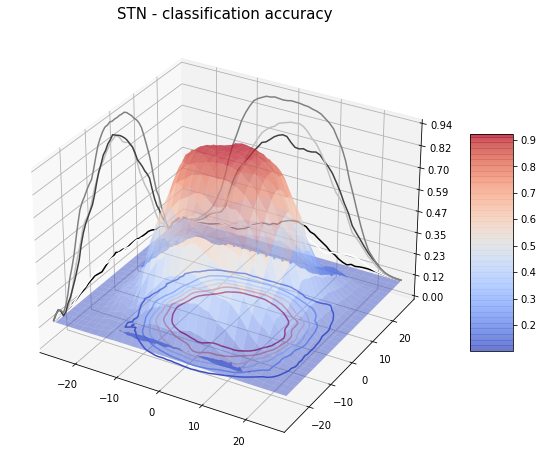

In [7]:
fig = plt.figure(figsize=(10,8))

for i in range(55):
    for j in range(55):
        accuracy_map[i,j] = max(accuracy_map[i,j], 0.1) # taking out values that are less than 10%

ax = fig.add_subplot(111, projection='3d')

# Creating a meshgrid of coordinates
X = np.arange(-27, 28)
Y = np.arange(-27, 28)
X, Y = np.meshgrid(X, Y) 

surf = ax.plot_surface(X, Y, accuracy_map, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True, alpha=0.5)

#ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
cset = ax.contour(X, Y, accuracy_map, [0.2, 0.3, 0.4, 0.5, 0.6, 0.7], zdir='z', offset=0, cmap=cm.coolwarm, alpha = 1)
cset = ax.contour(X, Y, accuracy_map, [-20, -10, 0, 10, 20], zdir='x', offset=-27.5, cmap = 'gray')
cset = ax.contour(X, Y, accuracy_map,  [-20, -10, 0, 10, 20], zdir='y', offset=27.5, cmap = 'gray')


# Customize the z axis.
ax.set_xlim(-27.5, 27.5)
ax.set_zlim(-27.5, 27.5)
ax.set_zlim(0, 0.94)
ax.zaxis.set_major_locator(LinearLocator(9))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title('STN - classification accuracy', size=15)

# Add a color bar which maps values to colors.
cbar = fig.colorbar(surf, shrink=0.5, aspect=5, ticks=[0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9])
fig.savefig('../figures/stn_28x28_accuracy_map.png', bbox_inches='tight', pad_inches=0.1)

# With Adam

In [59]:
def transform_to_numpy(image_grid, epoch):
    """
    This function transforms the PyTorch image grids
    into NumPy format that we will denormalize and save 
    as PNG file.
    """
    image_grid = image_grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_grid = std * image_grid + mean
    return image_grid

images = []
def stn_grid(epoch):
    """
    This function will pass one batch of the test
    image to the STN model and get the transformed images
    after each epoch to save as PNG file and also as
    GIFFY file.
    """
    with torch.no_grad():
        data = next(iter(test_loader))[0][:64, :, :, :].to(device)
        transformed_image = model.transformer_module.stn(data).cpu().detach()
        image_grid = torchvision.utils.make_grid(transformed_image)
        # save the grid image
        image_grid = transform_to_numpy(image_grid, epoch)
        plt.imshow(image_grid)
        plt.savefig(f"../figures/training/image_{epoch}.png")
        plt.close()
        images.append(image_grid)

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = STN().to(device)
optimizer = optim.Adam(model.parameters(), lr=args.lr)
#optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()
#images = []

In [62]:
model

STN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (transformer_module): SpatialTransformer(
    (localization): Sequential(
      (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ReLU(inplace=True)
    )
    (fc_loc): Sequential(
      (0): Linear(in_features=90, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=32, out_features=6, bias=True)
    )
  )
)

In [63]:
args.what_offset_std = 0

transform = transforms.Compose([
    WhatShift(args),
    WhatBackground(contrast=args.contrast,
                   noise=args.noise,
                   sf_0=args.sf_0,
                   B_sf=args.B_sf),
    transforms.ToTensor(),
    #transforms.Normalize((args.mean,), (args.std,))
])

train_loader = torch.utils.data.DataLoader(MNIST(
                                            '../data',
                                            train=True,
                                            download=True,
                                            transform=transform,
                                        ),
                                           batch_size=args.minibatch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST(
                                            '../data',
                                            train=False,
                                            download=True,
                                            transform=transform,
                                        ),
                                          batch_size=args.minibatch_size,
                                          shuffle=True)

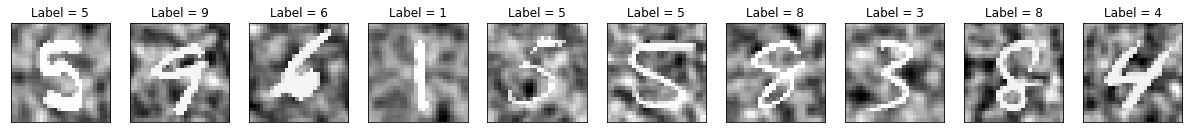

In [64]:
examples = view_dataset(test_loader)

In [65]:
print("Training on offset_std = %s" % (args.what_offset_std))
args.epochs = 5
for epoch in range(1, args.epochs + 1):
    train(epoch, train_loader)
    test(test_loader)
    #stn_grid(epoch)

Training on offset_std = 0
Train Epoch: 1/5 [0/60000 (0%)]	Loss: 2.308217
Train Epoch: 1/5 [10000/60000 (17%)]	Loss: 0.990102
Train Epoch: 1/5 [20000/60000 (33%)]	Loss: 0.694565
Train Epoch: 1/5 [30000/60000 (50%)]	Loss: 0.435259
Train Epoch: 1/5 [40000/60000 (67%)]	Loss: 0.254292
Train Epoch: 1/5 [50000/60000 (83%)]	Loss: 0.489097

Test set: Average loss: 0.0028, Accuracy: 9075/10000 (91%)

Train Epoch: 2/5 [0/60000 (0%)]	Loss: 0.199608
Train Epoch: 2/5 [10000/60000 (17%)]	Loss: 0.252975
Train Epoch: 2/5 [20000/60000 (33%)]	Loss: 0.282655
Train Epoch: 2/5 [30000/60000 (50%)]	Loss: 0.313791
Train Epoch: 2/5 [40000/60000 (67%)]	Loss: 0.201122
Train Epoch: 2/5 [50000/60000 (83%)]	Loss: 0.228801

Test set: Average loss: 0.0021, Accuracy: 9330/10000 (93%)

Train Epoch: 3/5 [0/60000 (0%)]	Loss: 0.239732
Train Epoch: 3/5 [10000/60000 (17%)]	Loss: 0.130484
Train Epoch: 3/5 [20000/60000 (33%)]	Loss: 0.124649
Train Epoch: 3/5 [30000/60000 (50%)]	Loss: 0.114963
Train Epoch: 3/5 [40000/60000 (67%

In [135]:
#imageio.mimsave('../figures/training/transformed_imgs.gif', images)

# Visualizing some digits after transformation

In [66]:
args.what_offset_std = 0

transform = transforms.Compose([
    WhatShift(args),
    WhatBackground(contrast=args.contrast,
                   noise=args.noise,
                   sf_0=args.sf_0,
                   B_sf=args.B_sf),
    transforms.ToTensor(),
    #transforms.Normalize((args.mean,), (args.std,))
])

train_loader = torch.utils.data.DataLoader(MNIST(
                                            '../data',
                                            train=True,
                                            download=True,
                                            transform=transform,
                                        ),
                                           batch_size=args.minibatch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST(
                                            '../data',
                                            train=False,
                                            download=True,
                                            transform=transform,
                                        ),
                                          batch_size=args.minibatch_size,
                                          shuffle=True)

In [67]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.

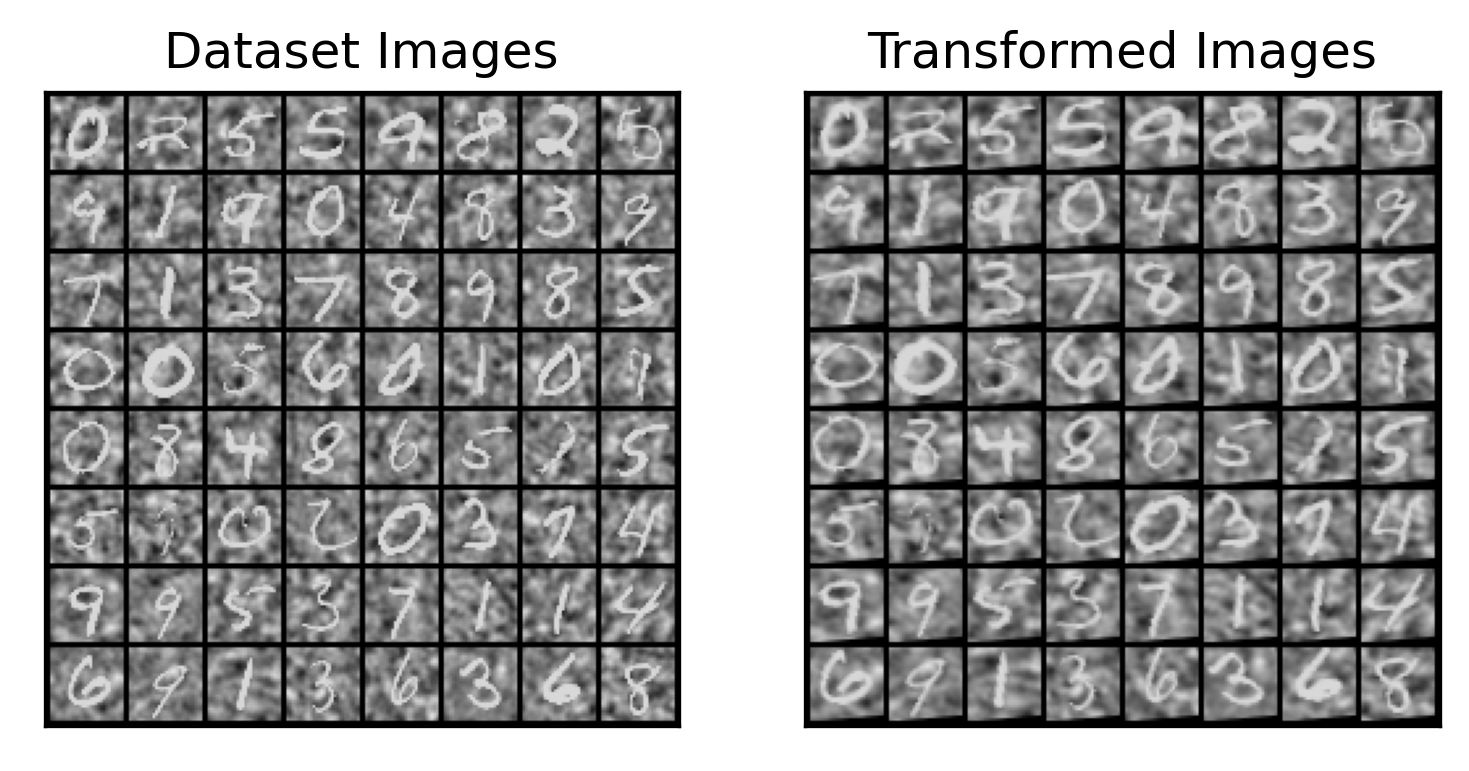

In [68]:
thetas = []
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0][:64, :, :, :].to(device) # taking only a batch of 64 for a better plot

        input_tensor = data.cpu()
        
        output_tensor, theta = model.transformer_module.stn(data)
        thetas.append(theta)
        
        transformed_input_tensor = output_tensor.cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2, dpi=300)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        axarr[0].set_xticks([])
        axarr[0].set_yticks([])

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')
        axarr[1].set_xticks([])
        axarr[1].set_yticks([])
        #f.savefig('../figures/results_trained.png')

visualize_stn()

In [72]:
thetas

[tensor([[[ 0.8009, -0.1385,  0.0831],
          [ 0.0834,  0.9430,  0.1175]],
 
         [[ 0.8009, -0.1385,  0.0831],
          [ 0.0834,  0.9430,  0.1175]],
 
         [[ 0.8009, -0.1385,  0.0831],
          [ 0.0834,  0.9430,  0.1175]],
 
         [[ 0.8009, -0.1385,  0.0831],
          [ 0.0834,  0.9430,  0.1175]],
 
         [[ 0.8009, -0.1385,  0.0831],
          [ 0.0834,  0.9430,  0.1175]],
 
         [[ 0.8009, -0.1385,  0.0831],
          [ 0.0834,  0.9430,  0.1175]],
 
         [[ 0.8009, -0.1385,  0.0831],
          [ 0.0834,  0.9430,  0.1175]],
 
         [[ 0.8009, -0.1385,  0.0831],
          [ 0.0834,  0.9430,  0.1175]],
 
         [[ 0.8009, -0.1385,  0.0831],
          [ 0.0834,  0.9430,  0.1175]],
 
         [[ 0.8009, -0.1385,  0.0831],
          [ 0.0834,  0.9430,  0.1175]],
 
         [[ 0.8009, -0.1385,  0.0831],
          [ 0.0834,  0.9430,  0.1175]],
 
         [[ 0.8009, -0.1385,  0.0831],
          [ 0.0834,  0.9430,  0.1175]],
 
         [[ 0.8009, -0.1385,

# With SGD

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = STN().to(device)
#optimizer = optim.Adam(model.parameters(), lr=args.lr)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

In [91]:
args.what_offset_std = 0

transform = transforms.Compose([
    WhatShift(args),
    WhatBackground(contrast=args.contrast,
                   noise=args.noise,
                   sf_0=args.sf_0,
                   B_sf=args.B_sf),
    transforms.ToTensor(),
    #transforms.Normalize((args.mean,), (args.std,))
])

train_loader = torch.utils.data.DataLoader(MNIST(
                                            '../data',
                                            train=True,
                                            download=True,
                                            transform=transform,
                                        ),
                                           batch_size=args.minibatch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST(
                                            '../data',
                                            train=False,
                                            download=True,
                                            transform=transform,
                                        ),
                                          batch_size=args.minibatch_size,
                                          shuffle=True)

In [92]:
print("Training on offset_std = %s" % (args.what_offset_std))
args.epochs = 20
for epoch in range(1, args.epochs + 1):
    train(epoch, train_loader)
    test(test_loader)

Training on offset_std = 0
Train Epoch: 1/20 [0/60000 (0%)]	Loss: 2.306917
Train Epoch: 1/20 [10000/60000 (17%)]	Loss: 2.303558
Train Epoch: 1/20 [20000/60000 (33%)]	Loss: 2.291733
Train Epoch: 1/20 [30000/60000 (50%)]	Loss: 2.285595
Train Epoch: 1/20 [40000/60000 (67%)]	Loss: 2.279186
Train Epoch: 1/20 [50000/60000 (83%)]	Loss: 2.282689

Test set: Average loss: 0.0226, Accuracy: 2450/10000 (24%)

Train Epoch: 2/20 [0/60000 (0%)]	Loss: 2.267286
Train Epoch: 2/20 [10000/60000 (17%)]	Loss: 2.245582
Train Epoch: 2/20 [20000/60000 (33%)]	Loss: 2.206098
Train Epoch: 2/20 [30000/60000 (50%)]	Loss: 2.088355
Train Epoch: 2/20 [40000/60000 (67%)]	Loss: 1.805057
Train Epoch: 2/20 [50000/60000 (83%)]	Loss: 1.496677

Test set: Average loss: 0.0128, Accuracy: 5737/10000 (57%)

Train Epoch: 3/20 [0/60000 (0%)]	Loss: 1.407343
Train Epoch: 3/20 [10000/60000 (17%)]	Loss: 1.049293
Train Epoch: 3/20 [20000/60000 (33%)]	Loss: 1.146770
Train Epoch: 3/20 [30000/60000 (50%)]	Loss: 0.997850
Train Epoch: 3/20 

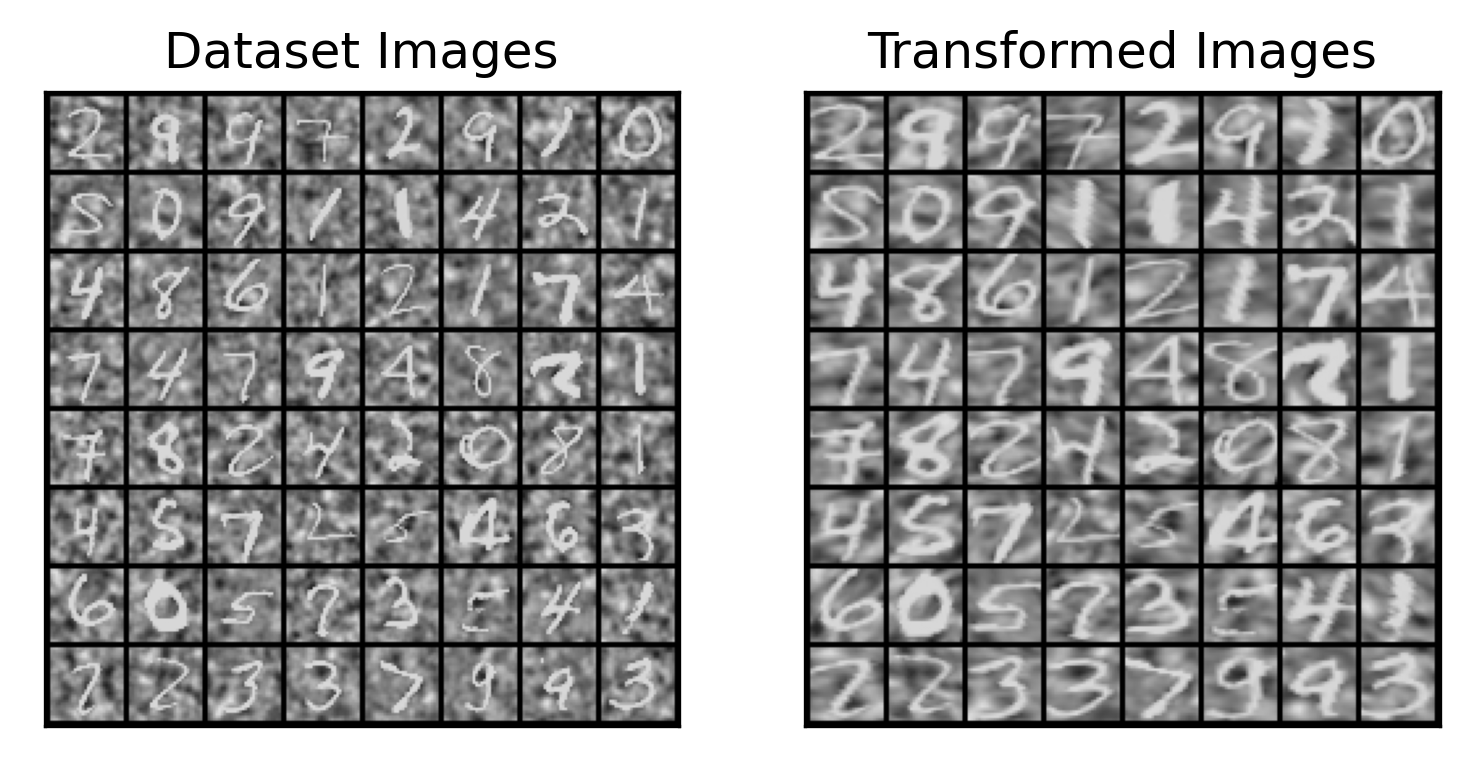

In [93]:
thetas = []
visualize_stn()

In [94]:
thetas

[tensor([[[ 5.5615e-01, -5.6817e-02,  3.5423e-02],
          [ 4.7883e-02,  9.0804e-01,  2.5441e-02]],
 
         [[ 5.2884e-01,  7.2026e-02, -2.2896e-03],
          [ 3.9347e-02,  7.8184e-01,  1.2992e-02]],
 
         [[ 7.1607e-01,  1.0545e-01,  3.7344e-02],
          [ 3.0872e-02,  8.4200e-01,  6.5165e-02]],
 
         [[ 5.2560e-01,  2.1639e-01,  1.4967e-02],
          [ 2.2121e-02,  7.5112e-01,  2.0245e-02]],
 
         [[ 4.0144e-01, -1.1391e-01,  3.8047e-02],
          [ 7.3487e-02,  8.3722e-01,  1.1629e-02]],
 
         [[ 6.4869e-01,  3.5806e-02,  1.9701e-02],
          [ 2.4441e-02,  7.9377e-01,  2.4148e-02]],
 
         [[ 4.6676e-01, -3.1718e-01,  2.2298e-02],
          [ 5.4611e-02,  7.6581e-01,  1.1724e-02]],
 
         [[ 8.0443e-01,  1.2004e-01,  4.1001e-02],
          [ 1.2427e-02,  8.4196e-01,  4.5144e-04]],
 
         [[ 6.8256e-01, -6.9306e-03,  2.5729e-02],
          [ 2.5574e-02,  7.3174e-01, -9.4689e-05]],
 
         [[ 6.0470e-01,  1.9348e-02,  1.8023e-02],
    